## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization

# put BN before Activation
def build_mlp_bf(input_shape, output_unit=10, num_neuros=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neuros):
        if i==0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_unit, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])    
    return model

# put BN after inputlayer
def build_mlp_af(input_shape, output_unit=10, num_neuros=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neuros):
            if i==0:
                x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
                x = BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
                x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_unit, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out]) 
    return model

In [11]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
BUILD_MLP = [build_mlp_bf, build_mlp_af]

In [12]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for bs, mlp in itertools.product(BATCH_SIZE, BUILD_MLP):
    keras.backend.clear_session()
    print('batch size:{}&build mlp:{}'.format(str(bs),str(mlp)))
    
    model = mlp(input_shape = x_train.shape[1:])
    model.summary()
    
    optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    model.fit(x_train, y_train,
             epochs=EPOCHS,
             batch_size=bs,
             validation_data =(x_test, y_test),
             shuffle=True)

    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['accuracy']
    valid_acc = model.history.history['val_accuracy']
    
    name_tag = 'batch size:{}&build mlp:{}'.format(str(bs),str(mlp))
    results[name_tag]= {'train-loss': train_loss, 'valid-loss': valid_loss,
                        'train-acc': train_acc, 'valid-acc': valid_acc}

batch size:2&build mlp:<function build_mlp_bf at 0x000001BBE738A268>
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
________________________________________________________

50000/50000 [==============================] - 492s 10ms/step - loss: 2.1946 - accuracy: 0.1913 - val_loss: 6783.8959 - val_accuracy: 0.1985
Epoch 45/50
50000/50000 [==============================] - 492s 10ms/step - loss: 2.2020 - accuracy: 0.1885 - val_loss: 12659.8888 - val_accuracy: 0.1979
Epoch 46/50
50000/50000 [==============================] - 491s 10ms/step - loss: 2.2004 - accuracy: 0.1853 - val_loss: 4397.4611 - val_accuracy: 0.2061
Epoch 47/50
50000/50000 [==============================] - 492s 10ms/step - loss: 2.1990 - accuracy: 0.1880 - val_loss: 8645.2637 - val_accuracy: 0.2237
Epoch 48/50
50000/50000 [==============================] - 496s 10ms/step - loss: 2.2008 - accuracy: 0.1873 - val_loss: 4036.1548 - val_accuracy: 0.2026
Epoch 49/50
50000/50000 [==============================] - 493s 10ms/step - loss: 2.2032 - accuracy: 0.1871 - val_loss: 5996.2570 - val_accuracy: 0.1900
Epoch 50/50
50000/50000 [==============================] - 492s 10ms/step - loss: 2.2042 - ac

50000/50000 [==============================] - 423s 8ms/step - loss: 2.2381 - accuracy: 0.1661 - val_loss: 7.2085 - val_accuracy: 0.1683
Epoch 39/50
50000/50000 [==============================] - 427s 9ms/step - loss: 2.2385 - accuracy: 0.1654 - val_loss: 8.6445 - val_accuracy: 0.1939
Epoch 40/50
50000/50000 [==============================] - 424s 8ms/step - loss: 2.2372 - accuracy: 0.1636 - val_loss: 6.3856 - val_accuracy: 0.1720
Epoch 41/50
50000/50000 [==============================] - 422s 8ms/step - loss: 2.2332 - accuracy: 0.1679 - val_loss: 7.7225 - val_accuracy: 0.1735
Epoch 42/50
50000/50000 [==============================] - 423s 8ms/step - loss: 2.2303 - accuracy: 0.1694 - val_loss: 18.8020 - val_accuracy: 0.1456
Epoch 43/50
50000/50000 [==============================] - 422s 8ms/step - loss: 2.2327 - accuracy: 0.1694 - val_loss: 35.3344 - val_accuracy: 0.1883
Epoch 44/50
50000/50000 [==============================] - 423s 8ms/step - loss: 2.2302 - accuracy: 0.1698 - val_los

50000/50000 [==============================] - 63s 1ms/step - loss: 0.7360 - accuracy: 0.7406 - val_loss: 1.4447 - val_accuracy: 0.5443
Epoch 33/50
50000/50000 [==============================] - 62s 1ms/step - loss: 0.7206 - accuracy: 0.7471 - val_loss: 1.4330 - val_accuracy: 0.5531
Epoch 34/50
50000/50000 [==============================] - 62s 1ms/step - loss: 0.7160 - accuracy: 0.7463 - val_loss: 1.4246 - val_accuracy: 0.5518
Epoch 35/50
50000/50000 [==============================] - 63s 1ms/step - loss: 0.7007 - accuracy: 0.7510 - val_loss: 1.4448 - val_accuracy: 0.5495
Epoch 36/50
50000/50000 [==============================] - 63s 1ms/step - loss: 0.6950 - accuracy: 0.7519 - val_loss: 1.4619 - val_accuracy: 0.5480
Epoch 37/50
50000/50000 [==============================] - 62s 1ms/step - loss: 0.6821 - accuracy: 0.7559 - val_loss: 1.4582 - val_accuracy: 0.5513
Epoch 38/50
50000/50000 [==============================] - 63s 1ms/step - loss: 0.6695 - accuracy: 0.7596 - val_loss: 1.4610

50000/50000 [==============================] - 56s 1ms/step - loss: 1.2108 - accuracy: 0.5708 - val_loss: 1.4032 - val_accuracy: 0.5110
Epoch 28/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.2081 - accuracy: 0.5731 - val_loss: 1.3439 - val_accuracy: 0.5280
Epoch 29/50
50000/50000 [==============================] - 56s 1ms/step - loss: 1.1958 - accuracy: 0.5751 - val_loss: 1.4094 - val_accuracy: 0.5118
Epoch 30/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.1910 - accuracy: 0.5809 - val_loss: 1.3401 - val_accuracy: 0.5331
Epoch 31/50
50000/50000 [==============================] - 56s 1ms/step - loss: 1.1904 - accuracy: 0.5787 - val_loss: 1.3230 - val_accuracy: 0.5355
Epoch 32/50
50000/50000 [==============================] - 56s 1ms/step - loss: 1.1756 - accuracy: 0.5840 - val_loss: 1.4013 - val_accuracy: 0.5139
Epoch 33/50
50000/50000 [==============================] - 56s 1ms/step - loss: 1.1753 - accuracy: 0.5838 - val_loss: 1.3277

Epoch 22/50
50000/50000 [==============================] - 36s 716us/step - loss: 0.5877 - accuracy: 0.7915 - val_loss: 1.5783 - val_accuracy: 0.5393
Epoch 23/50
50000/50000 [==============================] - 36s 720us/step - loss: 0.5663 - accuracy: 0.7982 - val_loss: 1.6016 - val_accuracy: 0.5408
Epoch 24/50
50000/50000 [==============================] - 36s 716us/step - loss: 0.5456 - accuracy: 0.8066 - val_loss: 1.6175 - val_accuracy: 0.5407
Epoch 25/50
50000/50000 [==============================] - 36s 715us/step - loss: 0.5269 - accuracy: 0.8117 - val_loss: 1.6378 - val_accuracy: 0.5422
Epoch 26/50
50000/50000 [==============================] - 36s 716us/step - loss: 0.5080 - accuracy: 0.8178 - val_loss: 1.6639 - val_accuracy: 0.5418
Epoch 27/50
50000/50000 [==============================] - 36s 717us/step - loss: 0.4906 - accuracy: 0.8260 - val_loss: 1.6788 - val_accuracy: 0.5469
Epoch 28/50
50000/50000 [==============================] - 36s 717us/step - loss: 0.4779 - accuracy:

50000/50000 [==============================] - 32s 634us/step - loss: 1.1523 - accuracy: 0.5892 - val_loss: 1.4575 - val_accuracy: 0.4902
Epoch 17/50
50000/50000 [==============================] - 32s 632us/step - loss: 1.1368 - accuracy: 0.5955 - val_loss: 1.4038 - val_accuracy: 0.5116
Epoch 18/50
50000/50000 [==============================] - 32s 633us/step - loss: 1.1244 - accuracy: 0.5996 - val_loss: 1.4177 - val_accuracy: 0.5072
Epoch 19/50
50000/50000 [==============================] - 32s 631us/step - loss: 1.0972 - accuracy: 0.6091 - val_loss: 1.7882 - val_accuracy: 0.4057
Epoch 20/50
50000/50000 [==============================] - 32s 631us/step - loss: 1.0840 - accuracy: 0.6141 - val_loss: 1.4517 - val_accuracy: 0.4986
Epoch 21/50
50000/50000 [==============================] - 32s 640us/step - loss: 1.0675 - accuracy: 0.6200 - val_loss: 1.4221 - val_accuracy: 0.5072
Epoch 22/50
50000/50000 [==============================] - 32s 634us/step - loss: 1.0529 - accuracy: 0.6267 - va

50000/50000 [==============================] - 17s 334us/step - loss: 0.8015 - accuracy: 0.7259 - val_loss: 1.4069 - val_accuracy: 0.5300
Epoch 11/50
50000/50000 [==============================] - 17s 335us/step - loss: 0.7483 - accuracy: 0.7451 - val_loss: 1.4274 - val_accuracy: 0.5294
Epoch 12/50
50000/50000 [==============================] - 17s 333us/step - loss: 0.6962 - accuracy: 0.7630 - val_loss: 1.4555 - val_accuracy: 0.5282
Epoch 13/50
50000/50000 [==============================] - 17s 337us/step - loss: 0.6407 - accuracy: 0.7828 - val_loss: 1.4948 - val_accuracy: 0.5287
Epoch 14/50
50000/50000 [==============================] - 17s 338us/step - loss: 0.5881 - accuracy: 0.8033 - val_loss: 1.5331 - val_accuracy: 0.5278
Epoch 15/50
50000/50000 [==============================] - 17s 336us/step - loss: 0.5436 - accuracy: 0.8184 - val_loss: 1.5664 - val_accuracy: 0.5345
Epoch 16/50
50000/50000 [==============================] - 17s 334us/step - loss: 0.5081 - accuracy: 0.8308 - va

50000/50000 [==============================] - 13s 264us/step - loss: 1.3285 - accuracy: 0.5322 - val_loss: 1.5227 - val_accuracy: 0.4672
Epoch 5/50
50000/50000 [==============================] - 12s 248us/step - loss: 1.2743 - accuracy: 0.5504 - val_loss: 1.5436 - val_accuracy: 0.4640
Epoch 6/50
50000/50000 [==============================] - 12s 244us/step - loss: 1.2257 - accuracy: 0.5696 - val_loss: 1.5687 - val_accuracy: 0.4494
Epoch 7/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.1773 - accuracy: 0.5850 - val_loss: 1.4970 - val_accuracy: 0.4829
Epoch 8/50
50000/50000 [==============================] - 13s 252us/step - loss: 1.1382 - accuracy: 0.6008 - val_loss: 1.5133 - val_accuracy: 0.4744
Epoch 9/50
50000/50000 [==============================] - 12s 248us/step - loss: 1.0929 - accuracy: 0.6171 - val_loss: 1.4733 - val_accuracy: 0.4802
Epoch 10/50
50000/50000 [==============================] - 12s 245us/step - loss: 1.0582 - accuracy: 0.6289 - val_los

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.8617 - accuracy: 0.3500 - val_loss: 1.7825 - val_accuracy: 0.3649
Epoch 2/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.5205 - accuracy: 0.4677 - val_loss: 1.5348 - val_accuracy: 0.4538
Epoch 3/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.3979 - accuracy: 0.5100 - val_loss: 1.4651 - val_accuracy: 0.4764
Epoch 4/50
50000/50000 [==============================] - 13s 256us/step - loss: 1.3089 - accuracy: 0.5438 - val_loss: 1.4350 - val_accuracy: 0.4882
Epoch 5/50
50000/50000 [==============================] - 14s 285us/step - loss: 1.2348 - accuracy: 0.5709 - val_loss: 1.4087 - val_accuracy: 0.4978
Epoch 6/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.1639 - accuracy: 0.5985 - val_loss: 1.4019 - val_accuracy: 0.4992
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.8600 - accuracy: 0.3603 - val_loss: 1.7637 - val_accuracy: 0.3815
Epoch 2/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.5527 - accuracy: 0.4569 - val_loss: 1.6218 - val_accuracy: 0.4268
Epoch 3/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.4514 - accuracy: 0.4907 - val_loss: 1.5897 - val_accuracy: 0.4370
Epoch 4/50
50000/50000 [==============================] - 9s 180us/step - loss: 1.3819 - accuracy: 0.5135 - val_loss: 1.5327 - val_accuracy: 0.4593
Epoch 5/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.3188 - accuracy: 0.5382 - val_loss: 1.5621 - val_accuracy: 0.4492
Epoch 6/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.2670 - accuracy: 0.5577 - val_loss: 1.4916 - val_accuracy: 0.4793
Epoch 7/50
50000/50000 [==============================] - 9s 1

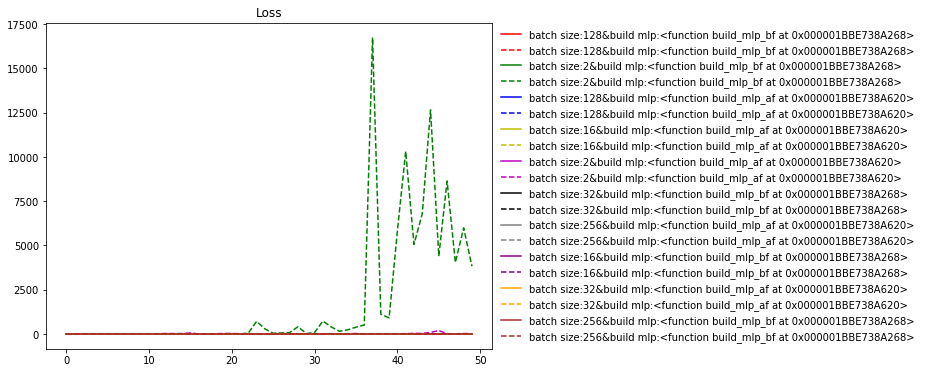

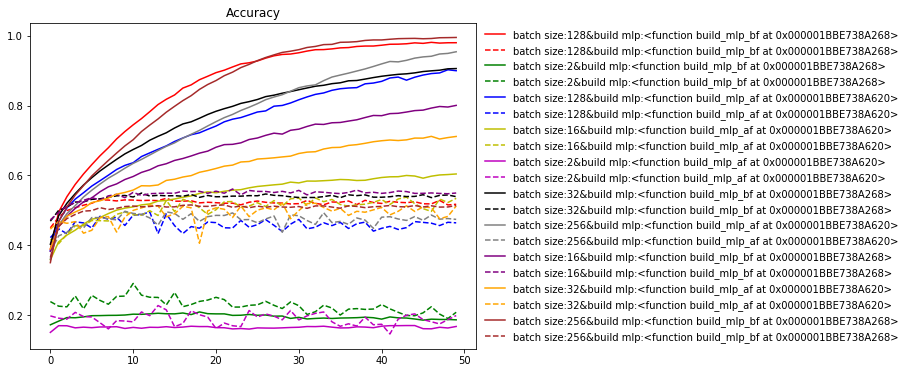

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ['r', 'g', 'b', 'y', 'm', 'k','gray','purple','orange','brown','pink','olive','cyan','gray']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title('Loss')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])), results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title('Accuracy')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()